In [1]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 11.9 MB/s eta 0:00:00


In [2]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127358 sha256=fdd5a1a98b3547bebcf79da2488985b539250dc20e35b4b810a6ae29bfaeb84e
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


In [5]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB",
  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 3,
    "max_eval_total": 300,
    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": true
      },
      "stopping_criteria": {
        "xatol": 1e-3,
        "fatol": 1e-3
      }
    }
  },
  "pulses": [
    {
      "pulse_name": "drive",
      "upper_limit": 1.5,
      "lower_limit": -1.5,
      "bins_number": 300,
      "time_name": "t",
      "basis": {
        "basis_name": "Fourier",
        "basis_vector_number": 6,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 0.1,
          "upper_limit": 5.0
        }
      },
      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.0*t"
      }
    }
  ],
  "parameters": [],
  "times": [
    {
      "time_name": "t",
      "initial_value": 200.0
    }
  ]
}


Writing opt_dictionary.json


In [6]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


two_pi = 2 * np.pi
def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3
def per_us_to_per_ns(rate):
    return rate * 1e-3

# Physical parameters
omega_a_MHz  = 2000.0
omega_b_MHz  = 2000.0
omega_eg_MHz = 2000.0
omega_ge1_MHz = 2000.0
omega_ge2_MHz = 2000.0
omega_gu1_MHz = 2800.0
omega_gu2_MHz = 2800.0
g_a_MHz = 260.0
g_b_MHz = 260.0
g1_MHz  = 7.0
g2_MHz  = 7.0

# convert
g_a = MHz_to_radns(g_a_MHz)
g_b = MHz_to_radns(g_b_MHz)
g1  = MHz_to_radns(g1_MHz)
g2  = MHz_to_radns(g2_MHz)
omega_a  = MHz_to_radns(omega_a_MHz)
omega_b  = MHz_to_radns(omega_b_MHz)
omega_eg = MHz_to_radns(omega_eg_MHz)
omega_ge1 = MHz_to_radns(omega_ge1_MHz)
omega_ge2 = MHz_to_radns(omega_ge2_MHz)
omega_gu1 = MHz_to_radns(omega_gu1_MHz)
omega_gu2 = MHz_to_radns(omega_gu2_MHz)

# detunings
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)

# Build operators once (72-dim Hilbert space)
def tensor_op(*ops):
    return qt.tensor(*ops)

a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)
S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# collapse operators (note: multiply sqrt(rate) by operator)
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# initial state (all ground/vacuum)
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)

# construct rho_T4 target
lambda_val = 0.90
g1_q = qt.basis(3,0)
e1_q = qt.basis(3,1)
g2_q = qt.basis(3,0)
e2_q = qt.basis(3,1)
NV_gg = qt.tensor(g1_q, g2_q)
NV_ee = qt.tensor(e1_q, e2_q)
NV_ge = qt.tensor(g1_q, e2_q)
NV_eg = qt.tensor(e1_q, g2_q)

rho_white_NV = (
    NV_gg*NV_gg.dag()
  + NV_ge*NV_ge.dag()
  + NV_eg*NV_eg.dag()
  + NV_ee*NV_ee.dag()
) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0)*qt.basis(2,0).dag()
proj_b = qt.basis(2,0)*qt.basis(2,0).dag()
proj_q = qt.basis(2,0)*qt.basis(2,0).dag()
rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_white_full = qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)
rho_T4 = lambda_val * rho_T3 + (1 - lambda_val) * rho_white_full

# FoM class for QuOCS
class HybridFoM(AbstractFoM):
    def __init__(self, args_dict=None):
        if args_dict is None:
            args_dict = {}
        # store static objects
        self.a = a; self.b = b
        self.sigma_plus = sigma_plus; self.sigma_minus = sigma_minus
        self.S1_ge_plus = S1_ge_plus; self.S1_ge_minus = S1_ge_minus
        self.S1_gu_plus = S1_gu_plus; self.S1_gu_minus = S1_gu_minus
        self.S2_ge_plus = S2_ge_plus; self.S2_ge_minus = S2_ge_minus
        self.S2_gu_plus = S2_gu_plus; self.S2_gu_minus = S2_gu_minus
        self.c_ops = c_ops_static
        self.psi0 = psi0
        self.rho_T4 = rho_T4
        # detunings & couplings
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.delta_a = delta_a; self.delta_b = delta_b
        self.delta1_ge = delta1_ge; self.delta1_gu = delta1_gu
        self.delta2_ge = delta2_ge; self.delta2_gu = delta2_gu

    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):
        """
        pulses[0] is the QuOCS-generated pulse array for 'drive' on the QuOCS internal grid (bins_number).
        timegrids[0] is the QuOCS time grid (in ns), with length equal to pulses[0]. We will interpolate
        that pulse onto the QuTiP 'times' grid used for simulation.
        """

        pulse_qocs = np.array(pulses[0])
        t_qocs = np.array(timegrids[0])  # QuOCS's internal grid (0..T)
        # We'll define the QuTiP simulation time grid (fine) here:
        T = float(t_qocs[-1])
        n_points = 3000  # keep your high resolution for solving; could be reduced for speed
        times = np.linspace(0.0, T, n_points)

        # interpolation function for pulse value at arbitrary t
        def pulse_interp(t):
            return np.interp(t, t_qocs, pulse_qocs)

        # construct time-dependent Hamiltonian H_t for QuTiP
        H_t = [
            # Resonator-qubit interactions (interaction picture phases)
            [ self.g_a * self.a * self.sigma_plus,        lambda t, args: np.exp(1j * self.delta_a * t) ],
            [ self.g_a * self.a.dag() * self.sigma_minus, lambda t, args: np.exp(-1j * self.delta_a * t) ],
            [ self.g_b * self.b * self.sigma_plus,        lambda t, args: np.exp(1j * self.delta_b * t) ],
            [ self.g_b * self.b.dag() * self.sigma_minus, lambda t, args: np.exp(-1j * self.delta_b * t) ],

            # NV1
            [ self.g1 * self.a * self.S1_ge_plus,        lambda t, args: np.exp(1j * self.delta1_ge * t) ],
            [ self.g1 * self.a.dag() * self.S1_ge_minus, lambda t, args: np.exp(-1j * self.delta1_ge * t) ],
            [ self.g1 * self.a * self.S1_gu_plus,        lambda t, args: np.exp(1j * self.delta1_gu * t) ],
            [ self.g1 * self.a.dag() * self.S1_gu_minus, lambda t, args: np.exp(-1j * self.delta1_gu * t) ],

            # NV2
            [ self.g2 * self.b * self.S2_ge_plus,        lambda t, args: np.exp(1j * self.delta2_ge * t) ],
            [ self.g2 * self.b.dag() * self.S2_ge_minus, lambda t, args: np.exp(-1j * self.delta2_ge * t) ],
            [ self.g2 * self.b * self.S2_gu_plus,        lambda t, args: np.exp(1j * self.delta2_gu * t) ],
            [ self.g2 * self.b.dag() * self.S2_gu_minus, lambda t, args: np.exp(-1j * self.delta2_gu * t) ],

            # Drive terms: replace Gaussian*Omega by pulse_interp(t) * e^{i delta t}
            [ self.a,     lambda t, args: pulse_interp(t) * np.exp(1j * self.delta_a * t) ],
            [ self.a.dag(), lambda t, args: np.conj(pulse_interp(t) * np.exp(1j * self.delta_a * t)) ],
            [ self.b,     lambda t, args: pulse_interp(t) * np.exp(1j * self.delta_b * t) ],
            [ self.b.dag(), lambda t, args: np.conj(pulse_interp(t) * np.exp(1j * self.delta_b * t)) ],
        ]

        # collapse operators (static)
        c_ops = self.c_ops

        # options & solve
        opts = qt.Options(store_states=True, nsteps=10000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, c_ops, [], options=opts)
        except Exception as e:
            # If solver fails, return bad FoM (optimizer will avoid)
            print("mesolve error:", e)
            return {"FoM": 1.0}  # worst (since we minimize 1 - F)

        # compute fidelity at final time with rho_T4
        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_T4)

        # QuOCS minimizes FoM. We want to maximize F, so return 1 - F (to minimize).
        fom_value = 1.0 - float(np.real(F))
        return {"FoM": fom_value}


Writing fom_hybrid.py


In [7]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer
from fom_hybrid import HybridFoM

# load opt dict
opt_dict = readjson("opt_dictionary.json")

# create FoM object
fom = HybridFoM()

# run optimizer
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
/usr/local/lib/python3.12/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.34749045541523904


/usr/local/lib/python3.12/dist-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))
INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.34749045541523904


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.34749045541523904


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.34749045541523904


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.6634300301319049


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.6634300301319049


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.9335655815055119


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.9335655815055119


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.702900337116656


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.702900337116656


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.7934452691421254


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.7934452691421254


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.8905399494037349


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.8905399494037349


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.8978183887078023


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.8978183887078023


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.810698268324535


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.810698268324535


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.931542026962387


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.931542026962387


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.8481681250015805


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 0.8481681250015805


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.8847643603385953


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 0.8847643603385953


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.9280457265409707


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 0, FoM: 0.9280457265409707


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.8087726067659926


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 0, FoM: 0.8087726067659926


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 0.9018020086423342


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 0.9018020086423342


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 2, FoM: 0.844737091269044


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 2, FoM: 0.844737091269044


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 3, FoM: 0.883778281695987


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 3, FoM: 0.883778281695987


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.7052477855153398


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.7052477855153398


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 5, FoM: 0.7786865869823734


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 5, FoM: 0.7786865869823734


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 6, FoM: 0.7447730404353949


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 6, FoM: 0.7447730404353949


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 7, FoM: 0.6227391235461276


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 7, FoM: 0.6227391235461276


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 8, FoM: 0.8750909954573206


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 8, FoM: 0.8750909954573206


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 8, FoM: 0.5708523735191857


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 8, FoM: 0.5708523735191857


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 9, FoM: 0.9549670282476365


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 9, FoM: 0.9549670282476365


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 9, FoM: 0.6657683968463484


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 9, FoM: 0.6657683968463484


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 10, FoM: 0.9071024181518791


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 10, FoM: 0.9071024181518791


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 10, FoM: 0.5692533208614305


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 10, FoM: 0.5692533208614305


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 11, FoM: 0.8222577750487784


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 11, FoM: 0.8222577750487784


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 11, FoM: 0.8642708059441291


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 11, FoM: 0.8642708059441291


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 11, FoM: 0.8523927232005613


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 11, FoM: 0.8523927232005613


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 11, FoM: 0.8276229333620385


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 11, FoM: 0.8276229333620385


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 11, FoM: 0.7741773284440023


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 11, FoM: 0.7741773284440023


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 11, FoM: 0.7488862846770261


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 11, FoM: 0.7488862846770261


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 11, FoM: 0.8954722840592468


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 11, FoM: 0.8954722840592468


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 11, FoM: 0.757392506741168


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 11, FoM: 0.757392506741168


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 11, FoM: 0.900059143272336


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 11, FoM: 0.900059143272336


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 11, FoM: 0.9552641659440158


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 11, FoM: 0.9552641659440158


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 11, FoM: 0.7999355966879113


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 11, FoM: 0.7999355966879113


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 11, FoM: 0.8944680166416091


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 11, FoM: 0.8944680166416091


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 11, FoM: 0.9252885535979917


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 11, FoM: 0.9252885535979917


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.7630896065310162


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.7630896065310162


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.8387480856353792


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.8387480856353792


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 13, FoM: 0.8688623236823099


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 13, FoM: 0.8688623236823099


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 14, FoM: 0.6103232339747988


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 14, FoM: 0.6103232339747988


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 15, FoM: 0.596116023536051


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 15, FoM: 0.596116023536051


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 16, FoM: 0.9407049271685476


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 16, FoM: 0.9407049271685476


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 16, FoM: 0.8662643548888149


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 16, FoM: 0.8662643548888149


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 17, FoM: 0.8368106458645266


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 17, FoM: 0.8368106458645266


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 18, FoM: 0.9285513354561394


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 18, FoM: 0.9285513354561394


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 18, FoM: 0.9492680804477606


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 18, FoM: 0.9492680804477606


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 18, FoM: 0.9153848069697269


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 18, FoM: 0.9153848069697269


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 18, FoM: 0.6025951535714351


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 18, FoM: 0.6025951535714351


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 18, FoM: 0.8103457941113672


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 18, FoM: 0.8103457941113672


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 18, FoM: 0.8297568279802987


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 18, FoM: 0.8297568279802987


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 18, FoM: 0.921447466796696


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 18, FoM: 0.921447466796696


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 18, FoM: 0.7772095236401174


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 18, FoM: 0.7772095236401174


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 18, FoM: 0.7848596988716858


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 18, FoM: 0.7848596988716858


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 18, FoM: 0.475434751885488


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 18, FoM: 0.475434751885488


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 18, FoM: 0.4856514575915142


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 18, FoM: 0.4856514575915142


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 18, FoM: 0.5285886633818271


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 18, FoM: 0.5285886633818271


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 18, FoM: 0.8419718047298064


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 18, FoM: 0.8419718047298064


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 18, FoM: 0.7936800624265916


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 18, FoM: 0.7936800624265916


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 19, FoM: 0.8799769159786164


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 19, FoM: 0.8799769159786164


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 20, FoM: 0.9613013206659685


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 20, FoM: 0.9613013206659685


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 20, FoM: 0.8725978589803955


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 20, FoM: 0.8725978589803955


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 21, FoM: 0.8953502914774512


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 21, FoM: 0.8953502914774512


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 21, FoM: 0.9615936058307165


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 21, FoM: 0.9615936058307165


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 21, FoM: 0.9427329096959273


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 21, FoM: 0.9427329096959273


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 21, FoM: 0.8434496352343933


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 21, FoM: 0.8434496352343933


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 21, FoM: 0.7015320445960455


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 21, FoM: 0.7015320445960455


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 21, FoM: 0.5956947105542358


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 21, FoM: 0.5956947105542358


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 21, FoM: 0.8373453945841643


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 21, FoM: 0.8373453945841643


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.9014790511360509


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 21, FoM: 0.9014790511360509


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.9384984413776181


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.9384984413776181


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.7168434959725158


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.7168434959725158


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 21, FoM: 0.8513461708804998


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 21, FoM: 0.8513461708804998


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 21, FoM: 0.9617171389621518


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 21, FoM: 0.9617171389621518


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 21, FoM: 0.7851410584898477


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 21, FoM: 0.7851410584898477


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 21, FoM: 0.924395190896611


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 21, FoM: 0.924395190896611


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 22, FoM: 0.9046668378657381


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 22, FoM: 0.9046668378657381


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 23, FoM: 0.9275310275403312


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 23, FoM: 0.9275310275403312


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 24, FoM: 0.7441338858885906


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 24, FoM: 0.7441338858885906


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 25, FoM: 0.7493179610567811


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 25, FoM: 0.7493179610567811


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 26, FoM: 0.47492106352368413


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 26, FoM: 0.47492106352368413


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 27, FoM: 0.6329047890572983


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 27, FoM: 0.6329047890572983


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 28, FoM: 0.8622919684596785


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 28, FoM: 0.8622919684596785


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.5421482478484049


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.5421482478484049


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.8065795463086095


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.8065795463086095


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 30, FoM: 0.9224290390327834


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 30, FoM: 0.9224290390327834


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.837207455861209


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.837207455861209


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.8306401835676172


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 31, FoM: 0.8306401835676172


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.7699888988420508


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 32, FoM: 0.7699888988420508


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.8634627743779126


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 33, FoM: 0.8634627743779126


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.9543696063344576


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 33, FoM: 0.9543696063344576


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 33, FoM: 0.8221831597931417


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 33, FoM: 0.8221831597931417


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.9297481097946698


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.9297481097946698


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.816007294594685


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.816007294594685


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 33, FoM: 0.9061764069696433


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 33, FoM: 0.9061764069696433


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 33, FoM: 0.8579176293118873


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 33, FoM: 0.8579176293118873


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 33, FoM: 0.5144655796363857


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 33, FoM: 0.5144655796363857


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 33, FoM: 0.8819847456025721


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 33, FoM: 0.8819847456025721


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 33, FoM: 0.5295327738764943


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 33, FoM: 0.5295327738764943


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 33, FoM: 0.9430575612986855


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 33, FoM: 0.9430575612986855


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 33, FoM: 0.5147286044453137


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 33, FoM: 0.5147286044453137


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 33, FoM: 0.8951853259156054


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 33, FoM: 0.8951853259156054


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 33, FoM: 0.43748365196831285


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 33, FoM: 0.43748365196831285


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 34, FoM: 0.8524128824955273


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 34, FoM: 0.8524128824955273


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 35, FoM: 0.8897099549157814


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 35, FoM: 0.8897099549157814


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 36, FoM: 0.8971692940861989


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 36, FoM: 0.8971692940861989


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 36, FoM: 0.7643047835734387


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 36, FoM: 0.7643047835734387


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 37, FoM: 0.6851038092081994


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 37, FoM: 0.6851038092081994


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 38, FoM: 0.4930827353099667


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 38, FoM: 0.4930827353099667


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 39, FoM: 0.8621078669449691


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 39, FoM: 0.8621078669449691


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 39, FoM: 0.9481463768522717


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 39, FoM: 0.9481463768522717


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 39, FoM: 0.6349585836304406


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 39, FoM: 0.6349585836304406


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 39, FoM: 0.8306983419149037


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 39, FoM: 0.8306983419149037


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 39, FoM: 0.6611790290030954


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 39, FoM: 0.6611790290030954


INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 39, FoM: 0.8297978964059911


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 39, FoM: 0.8297978964059911


INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 39, FoM: 0.7277549973964621


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 39, FoM: 0.7277549973964621


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 39, FoM: 0.9344133729352696


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 39, FoM: 0.9344133729352696


INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 39, FoM: 0.7196977354362158


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 39, FoM: 0.7196977354362158


INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 39, FoM: 0.5481450078419845


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 39, FoM: 0.5481450078419845


INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 39, FoM: 0.788170776919977


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 39, FoM: 0.788170776919977


INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 39, FoM: 0.9588611005614556


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 39, FoM: 0.9588611005614556


INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 39, FoM: 0.8466970198669276


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 39, FoM: 0.8466970198669276


INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 39, FoM: 0.5257754862378472


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 39, FoM: 0.5257754862378472


INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 40, FoM: 0.6697834914694573


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 40, FoM: 0.6697834914694573


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 41, FoM: 0.9679531754628147


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 41, FoM: 0.9679531754628147


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 41, FoM: 0.846108742923719


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 41, FoM: 0.846108742923719


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 42, FoM: 0.8039145012439552


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 42, FoM: 0.8039145012439552


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 43, FoM: 0.463444190685544


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 43, FoM: 0.463444190685544


INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 44, FoM: 0.7771296726816371


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 44, FoM: 0.7771296726816371


INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 45, FoM: 0.7380253903052181


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 45, FoM: 0.7380253903052181


INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 46, FoM: 0.8892306204938348


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 46, FoM: 0.8892306204938348


INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 46, FoM: 0.9603804141389249


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 46, FoM: 0.9603804141389249


INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 46, FoM: 0.7774495679865842


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 46, FoM: 0.7774495679865842


INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 46, FoM: 0.8175635127983478


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 46, FoM: 0.8175635127983478


INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 46, FoM: 0.7264534564565062


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 46, FoM: 0.7264534564565062


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 46, FoM: 0.7764734338788581


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 46, FoM: 0.7764734338788581


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 46, FoM: 0.7497893002033524


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 46, FoM: 0.7497893002033524


INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 46, FoM: 0.8475749798331971


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 46, FoM: 0.8475749798331971


INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 46, FoM: 0.7435761522687703


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 46, FoM: 0.7435761522687703


INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 46, FoM: 0.9441551645136514


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 46, FoM: 0.9441551645136514


INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 46, FoM: 0.8715816422192172


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 46, FoM: 0.8715816422192172


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 46, FoM: 0.48603962991518324


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 46, FoM: 0.48603962991518324


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 46, FoM: 0.7710146898547426


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 46, FoM: 0.7710146898547426


INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 46, FoM: 0.7693248464092222


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 46, FoM: 0.7693248464092222


INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 47, FoM: 0.6810838669865207


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 47, FoM: 0.6810838669865207


INFO     oc_logger    Function evaluation number: 148, SI: 1, Sub-iteration number: 48, FoM: 0.9483488485659549


INFO:oc_logger:Function evaluation number: 148, SI: 1, Sub-iteration number: 48, FoM: 0.9483488485659549


INFO     oc_logger    Function evaluation number: 149, SI: 1, Sub-iteration number: 48, FoM: 0.6290633071355791


INFO:oc_logger:Function evaluation number: 149, SI: 1, Sub-iteration number: 48, FoM: 0.6290633071355791


INFO     oc_logger    Function evaluation number: 150, SI: 1, Sub-iteration number: 49, FoM: 0.8987229019075889


INFO:oc_logger:Function evaluation number: 150, SI: 1, Sub-iteration number: 49, FoM: 0.8987229019075889


INFO     oc_logger    Function evaluation number: 151, SI: 1, Sub-iteration number: 49, FoM: 0.5828402125188757


INFO:oc_logger:Function evaluation number: 151, SI: 1, Sub-iteration number: 49, FoM: 0.5828402125188757


INFO     oc_logger    Function evaluation number: 152, SI: 1, Sub-iteration number: 50, FoM: 0.4154779582205804


INFO:oc_logger:Function evaluation number: 152, SI: 1, Sub-iteration number: 50, FoM: 0.4154779582205804


INFO     oc_logger    Function evaluation number: 153, SI: 1, Sub-iteration number: 51, FoM: 0.826570856666265


INFO:oc_logger:Function evaluation number: 153, SI: 1, Sub-iteration number: 51, FoM: 0.826570856666265


INFO     oc_logger    Function evaluation number: 154, SI: 1, Sub-iteration number: 51, FoM: 0.8615112428182633


INFO:oc_logger:Function evaluation number: 154, SI: 1, Sub-iteration number: 51, FoM: 0.8615112428182633


INFO     oc_logger    Function evaluation number: 155, SI: 1, Sub-iteration number: 51, FoM: 0.5880932800736416


INFO:oc_logger:Function evaluation number: 155, SI: 1, Sub-iteration number: 51, FoM: 0.5880932800736416


INFO     oc_logger    Function evaluation number: 156, SI: 1, Sub-iteration number: 51, FoM: 0.89678365662032


INFO:oc_logger:Function evaluation number: 156, SI: 1, Sub-iteration number: 51, FoM: 0.89678365662032


INFO     oc_logger    Function evaluation number: 157, SI: 1, Sub-iteration number: 51, FoM: 0.8458051372023401


INFO:oc_logger:Function evaluation number: 157, SI: 1, Sub-iteration number: 51, FoM: 0.8458051372023401


INFO     oc_logger    Function evaluation number: 158, SI: 1, Sub-iteration number: 51, FoM: 0.8253837608625352


INFO:oc_logger:Function evaluation number: 158, SI: 1, Sub-iteration number: 51, FoM: 0.8253837608625352


INFO     oc_logger    Function evaluation number: 159, SI: 1, Sub-iteration number: 51, FoM: 0.8146389019954012


INFO:oc_logger:Function evaluation number: 159, SI: 1, Sub-iteration number: 51, FoM: 0.8146389019954012


INFO     oc_logger    Function evaluation number: 160, SI: 1, Sub-iteration number: 51, FoM: 0.8386108483476867


INFO:oc_logger:Function evaluation number: 160, SI: 1, Sub-iteration number: 51, FoM: 0.8386108483476867


INFO     oc_logger    Function evaluation number: 161, SI: 1, Sub-iteration number: 51, FoM: 0.6500716905575592


INFO:oc_logger:Function evaluation number: 161, SI: 1, Sub-iteration number: 51, FoM: 0.6500716905575592


INFO     oc_logger    Function evaluation number: 162, SI: 1, Sub-iteration number: 51, FoM: 0.6137973775880876


INFO:oc_logger:Function evaluation number: 162, SI: 1, Sub-iteration number: 51, FoM: 0.6137973775880876


INFO     oc_logger    Function evaluation number: 163, SI: 1, Sub-iteration number: 51, FoM: 0.8797800036611548


INFO:oc_logger:Function evaluation number: 163, SI: 1, Sub-iteration number: 51, FoM: 0.8797800036611548


INFO     oc_logger    Function evaluation number: 164, SI: 1, Sub-iteration number: 51, FoM: 0.35360847152069586


INFO:oc_logger:Function evaluation number: 164, SI: 1, Sub-iteration number: 51, FoM: 0.35360847152069586


INFO     oc_logger    Function evaluation number: 165, SI: 1, Sub-iteration number: 51, FoM: 0.6162931705375754


INFO:oc_logger:Function evaluation number: 165, SI: 1, Sub-iteration number: 51, FoM: 0.6162931705375754


INFO     oc_logger    Function evaluation number: 166, SI: 1, Sub-iteration number: 51, FoM: 0.6832900732418534


INFO:oc_logger:Function evaluation number: 166, SI: 1, Sub-iteration number: 51, FoM: 0.6832900732418534


INFO     oc_logger    Function evaluation number: 167, SI: 1, Sub-iteration number: 52, FoM: 0.6876105691516259


INFO:oc_logger:Function evaluation number: 167, SI: 1, Sub-iteration number: 52, FoM: 0.6876105691516259


INFO     oc_logger    Function evaluation number: 168, SI: 1, Sub-iteration number: 53, FoM: 0.6345987266730055


INFO:oc_logger:Function evaluation number: 168, SI: 1, Sub-iteration number: 53, FoM: 0.6345987266730055


INFO     oc_logger    Function evaluation number: 169, SI: 1, Sub-iteration number: 54, FoM: 0.5353546353707119


INFO:oc_logger:Function evaluation number: 169, SI: 1, Sub-iteration number: 54, FoM: 0.5353546353707119


INFO     oc_logger    Function evaluation number: 170, SI: 1, Sub-iteration number: 55, FoM: 0.6879556668773819


INFO:oc_logger:Function evaluation number: 170, SI: 1, Sub-iteration number: 55, FoM: 0.6879556668773819


INFO     oc_logger    Function evaluation number: 171, SI: 1, Sub-iteration number: 56, FoM: 0.7102890138553248


INFO:oc_logger:Function evaluation number: 171, SI: 1, Sub-iteration number: 56, FoM: 0.7102890138553248


INFO     oc_logger    Function evaluation number: 172, SI: 1, Sub-iteration number: 57, FoM: 0.9466446727498588


INFO:oc_logger:Function evaluation number: 172, SI: 1, Sub-iteration number: 57, FoM: 0.9466446727498588


INFO     oc_logger    Function evaluation number: 173, SI: 1, Sub-iteration number: 57, FoM: 0.3775717406155872


INFO:oc_logger:Function evaluation number: 173, SI: 1, Sub-iteration number: 57, FoM: 0.3775717406155872


INFO     oc_logger    Function evaluation number: 174, SI: 1, Sub-iteration number: 58, FoM: 0.7375026153653833


INFO:oc_logger:Function evaluation number: 174, SI: 1, Sub-iteration number: 58, FoM: 0.7375026153653833


INFO     oc_logger    Function evaluation number: 175, SI: 1, Sub-iteration number: 58, FoM: 0.9233127591023446


INFO:oc_logger:Function evaluation number: 175, SI: 1, Sub-iteration number: 58, FoM: 0.9233127591023446


INFO     oc_logger    Function evaluation number: 176, SI: 1, Sub-iteration number: 58, FoM: 0.5753347833748426


INFO:oc_logger:Function evaluation number: 176, SI: 1, Sub-iteration number: 58, FoM: 0.5753347833748426


INFO     oc_logger    Function evaluation number: 177, SI: 1, Sub-iteration number: 58, FoM: 0.7602265242581367


INFO:oc_logger:Function evaluation number: 177, SI: 1, Sub-iteration number: 58, FoM: 0.7602265242581367


INFO     oc_logger    New record achieved. Previous FoM: 0.34749045541523904, new best FoM : 0.2837345611493577


INFO:oc_logger:New record achieved. Previous FoM: 0.34749045541523904, new best FoM : 0.2837345611493577


INFO     oc_logger    Function evaluation number: 178, SI: 1, Sub-iteration number: 58, FoM: 0.2837345611493577


INFO:oc_logger:Function evaluation number: 178, SI: 1, Sub-iteration number: 58, FoM: 0.2837345611493577


INFO     oc_logger    Function evaluation number: 179, SI: 1, Sub-iteration number: 58, FoM: 0.5541224105171345


INFO:oc_logger:Function evaluation number: 179, SI: 1, Sub-iteration number: 58, FoM: 0.5541224105171345


INFO     oc_logger    Function evaluation number: 180, SI: 1, Sub-iteration number: 58, FoM: 0.6498286583136745


INFO:oc_logger:Function evaluation number: 180, SI: 1, Sub-iteration number: 58, FoM: 0.6498286583136745


INFO     oc_logger    Function evaluation number: 181, SI: 1, Sub-iteration number: 58, FoM: 0.4699140141981193


INFO:oc_logger:Function evaluation number: 181, SI: 1, Sub-iteration number: 58, FoM: 0.4699140141981193


INFO     oc_logger    Function evaluation number: 182, SI: 1, Sub-iteration number: 58, FoM: 0.6819778819078851


INFO:oc_logger:Function evaluation number: 182, SI: 1, Sub-iteration number: 58, FoM: 0.6819778819078851


INFO     oc_logger    Function evaluation number: 183, SI: 1, Sub-iteration number: 58, FoM: 0.5948950977505758


INFO:oc_logger:Function evaluation number: 183, SI: 1, Sub-iteration number: 58, FoM: 0.5948950977505758


INFO     oc_logger    Function evaluation number: 184, SI: 1, Sub-iteration number: 58, FoM: 0.9012924065490444


INFO:oc_logger:Function evaluation number: 184, SI: 1, Sub-iteration number: 58, FoM: 0.9012924065490444


INFO     oc_logger    Function evaluation number: 185, SI: 1, Sub-iteration number: 58, FoM: 0.7672657673959152


INFO:oc_logger:Function evaluation number: 185, SI: 1, Sub-iteration number: 58, FoM: 0.7672657673959152


INFO     oc_logger    Function evaluation number: 186, SI: 1, Sub-iteration number: 58, FoM: 0.8866512537440526


INFO:oc_logger:Function evaluation number: 186, SI: 1, Sub-iteration number: 58, FoM: 0.8866512537440526


INFO     oc_logger    Function evaluation number: 187, SI: 1, Sub-iteration number: 58, FoM: 0.5311941126873727


INFO:oc_logger:Function evaluation number: 187, SI: 1, Sub-iteration number: 58, FoM: 0.5311941126873727


INFO     oc_logger    Function evaluation number: 188, SI: 1, Sub-iteration number: 59, FoM: 0.8392190356243656


INFO:oc_logger:Function evaluation number: 188, SI: 1, Sub-iteration number: 59, FoM: 0.8392190356243656


INFO     oc_logger    Function evaluation number: 189, SI: 1, Sub-iteration number: 60, FoM: 0.6281511755985901


INFO:oc_logger:Function evaluation number: 189, SI: 1, Sub-iteration number: 60, FoM: 0.6281511755985901


INFO     oc_logger    Function evaluation number: 190, SI: 1, Sub-iteration number: 61, FoM: 0.8619562807121758


INFO:oc_logger:Function evaluation number: 190, SI: 1, Sub-iteration number: 61, FoM: 0.8619562807121758


INFO     oc_logger    Function evaluation number: 191, SI: 1, Sub-iteration number: 61, FoM: 0.6056172239470936


INFO:oc_logger:Function evaluation number: 191, SI: 1, Sub-iteration number: 61, FoM: 0.6056172239470936


INFO     oc_logger    Function evaluation number: 192, SI: 1, Sub-iteration number: 62, FoM: 0.8511681860099857


INFO:oc_logger:Function evaluation number: 192, SI: 1, Sub-iteration number: 62, FoM: 0.8511681860099857


INFO     oc_logger    Function evaluation number: 193, SI: 1, Sub-iteration number: 62, FoM: 0.8837755902204762


INFO:oc_logger:Function evaluation number: 193, SI: 1, Sub-iteration number: 62, FoM: 0.8837755902204762


INFO     oc_logger    Function evaluation number: 194, SI: 1, Sub-iteration number: 62, FoM: 0.8665631887998321


INFO:oc_logger:Function evaluation number: 194, SI: 1, Sub-iteration number: 62, FoM: 0.8665631887998321


INFO     oc_logger    Function evaluation number: 195, SI: 1, Sub-iteration number: 62, FoM: 0.7503730919093239


INFO:oc_logger:Function evaluation number: 195, SI: 1, Sub-iteration number: 62, FoM: 0.7503730919093239


INFO     oc_logger    Function evaluation number: 196, SI: 1, Sub-iteration number: 62, FoM: 0.8039075170093658


INFO:oc_logger:Function evaluation number: 196, SI: 1, Sub-iteration number: 62, FoM: 0.8039075170093658


INFO     oc_logger    Function evaluation number: 197, SI: 1, Sub-iteration number: 62, FoM: 0.9625007440608814


INFO:oc_logger:Function evaluation number: 197, SI: 1, Sub-iteration number: 62, FoM: 0.9625007440608814


INFO     oc_logger    Function evaluation number: 198, SI: 1, Sub-iteration number: 62, FoM: 0.9137452819218763


INFO:oc_logger:Function evaluation number: 198, SI: 1, Sub-iteration number: 62, FoM: 0.9137452819218763


INFO     oc_logger    Function evaluation number: 199, SI: 1, Sub-iteration number: 62, FoM: 0.9080012344413937


INFO:oc_logger:Function evaluation number: 199, SI: 1, Sub-iteration number: 62, FoM: 0.9080012344413937


INFO     oc_logger    Function evaluation number: 200, SI: 1, Sub-iteration number: 62, FoM: 0.679259865006755


INFO:oc_logger:Function evaluation number: 200, SI: 1, Sub-iteration number: 62, FoM: 0.679259865006755


INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 62, FoM: 0.6554995715612373


INFO:oc_logger:Function evaluation number: 201, SI: 1, Sub-iteration number: 62, FoM: 0.6554995715612373


INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 62, FoM: 0.885733396654252


INFO:oc_logger:Function evaluation number: 202, SI: 1, Sub-iteration number: 62, FoM: 0.885733396654252


INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 62, FoM: 0.9201281711291324


INFO:oc_logger:Function evaluation number: 203, SI: 1, Sub-iteration number: 62, FoM: 0.9201281711291324


INFO     oc_logger    Function evaluation number: 204, SI: 1, Sub-iteration number: 62, FoM: 0.8204166866120097


INFO:oc_logger:Function evaluation number: 204, SI: 1, Sub-iteration number: 62, FoM: 0.8204166866120097


INFO     oc_logger    Function evaluation number: 205, SI: 1, Sub-iteration number: 62, FoM: 0.3849047992455048


INFO:oc_logger:Function evaluation number: 205, SI: 1, Sub-iteration number: 62, FoM: 0.3849047992455048


INFO     oc_logger    Function evaluation number: 206, SI: 1, Sub-iteration number: 63, FoM: 0.9344058832499585


INFO:oc_logger:Function evaluation number: 206, SI: 1, Sub-iteration number: 63, FoM: 0.9344058832499585


INFO     oc_logger    Function evaluation number: 207, SI: 1, Sub-iteration number: 63, FoM: 0.8629440403687775


INFO:oc_logger:Function evaluation number: 207, SI: 1, Sub-iteration number: 63, FoM: 0.8629440403687775


INFO     oc_logger    Function evaluation number: 208, SI: 1, Sub-iteration number: 64, FoM: 0.8386285097177049


INFO:oc_logger:Function evaluation number: 208, SI: 1, Sub-iteration number: 64, FoM: 0.8386285097177049


INFO     oc_logger    Function evaluation number: 209, SI: 1, Sub-iteration number: 65, FoM: 0.8862589598985675


INFO:oc_logger:Function evaluation number: 209, SI: 1, Sub-iteration number: 65, FoM: 0.8862589598985675


INFO     oc_logger    Function evaluation number: 210, SI: 1, Sub-iteration number: 66, FoM: 0.7947447976909141


INFO:oc_logger:Function evaluation number: 210, SI: 1, Sub-iteration number: 66, FoM: 0.7947447976909141


INFO     oc_logger    Function evaluation number: 211, SI: 1, Sub-iteration number: 67, FoM: 0.9652741639281028


INFO:oc_logger:Function evaluation number: 211, SI: 1, Sub-iteration number: 67, FoM: 0.9652741639281028


INFO     oc_logger    Function evaluation number: 212, SI: 1, Sub-iteration number: 67, FoM: 0.9391310135576374


INFO:oc_logger:Function evaluation number: 212, SI: 1, Sub-iteration number: 67, FoM: 0.9391310135576374


INFO     oc_logger    New record achieved. Previous FoM: 0.2837345611493577, new best FoM : 0.20318404353220354


INFO:oc_logger:New record achieved. Previous FoM: 0.2837345611493577, new best FoM : 0.20318404353220354


INFO     oc_logger    Function evaluation number: 213, SI: 1, Sub-iteration number: 67, FoM: 0.20318404353220354


INFO:oc_logger:Function evaluation number: 213, SI: 1, Sub-iteration number: 67, FoM: 0.20318404353220354


INFO     oc_logger    Function evaluation number: 214, SI: 1, Sub-iteration number: 67, FoM: 0.23722216490899084


INFO:oc_logger:Function evaluation number: 214, SI: 1, Sub-iteration number: 67, FoM: 0.23722216490899084


INFO     oc_logger    Function evaluation number: 215, SI: 1, Sub-iteration number: 67, FoM: 0.5741758103589774


INFO:oc_logger:Function evaluation number: 215, SI: 1, Sub-iteration number: 67, FoM: 0.5741758103589774


INFO     oc_logger    Function evaluation number: 216, SI: 1, Sub-iteration number: 67, FoM: 0.9429184902664121


INFO:oc_logger:Function evaluation number: 216, SI: 1, Sub-iteration number: 67, FoM: 0.9429184902664121


INFO     oc_logger    Function evaluation number: 217, SI: 1, Sub-iteration number: 67, FoM: 0.8684717442725903


INFO:oc_logger:Function evaluation number: 217, SI: 1, Sub-iteration number: 67, FoM: 0.8684717442725903


INFO     oc_logger    Function evaluation number: 218, SI: 1, Sub-iteration number: 67, FoM: 0.7668259887502664


INFO:oc_logger:Function evaluation number: 218, SI: 1, Sub-iteration number: 67, FoM: 0.7668259887502664


INFO     oc_logger    Function evaluation number: 219, SI: 1, Sub-iteration number: 67, FoM: 0.4989232618495003


INFO:oc_logger:Function evaluation number: 219, SI: 1, Sub-iteration number: 67, FoM: 0.4989232618495003


INFO     oc_logger    Function evaluation number: 220, SI: 1, Sub-iteration number: 67, FoM: 0.4315185998745713


INFO:oc_logger:Function evaluation number: 220, SI: 1, Sub-iteration number: 67, FoM: 0.4315185998745713


INFO     oc_logger    Function evaluation number: 221, SI: 1, Sub-iteration number: 67, FoM: 0.9062487285241685


INFO:oc_logger:Function evaluation number: 221, SI: 1, Sub-iteration number: 67, FoM: 0.9062487285241685


INFO     oc_logger    Function evaluation number: 222, SI: 1, Sub-iteration number: 67, FoM: 0.6627754801170713


INFO:oc_logger:Function evaluation number: 222, SI: 1, Sub-iteration number: 67, FoM: 0.6627754801170713


INFO     oc_logger    Function evaluation number: 223, SI: 1, Sub-iteration number: 67, FoM: 0.9606811690483792


INFO:oc_logger:Function evaluation number: 223, SI: 1, Sub-iteration number: 67, FoM: 0.9606811690483792


INFO     oc_logger    Function evaluation number: 224, SI: 1, Sub-iteration number: 67, FoM: 0.7621083907468361


INFO:oc_logger:Function evaluation number: 224, SI: 1, Sub-iteration number: 67, FoM: 0.7621083907468361


INFO     oc_logger    Function evaluation number: 225, SI: 1, Sub-iteration number: 68, FoM: 0.803985905912384


INFO:oc_logger:Function evaluation number: 225, SI: 1, Sub-iteration number: 68, FoM: 0.803985905912384


INFO     oc_logger    Function evaluation number: 226, SI: 1, Sub-iteration number: 69, FoM: 0.3517119106902018


INFO:oc_logger:Function evaluation number: 226, SI: 1, Sub-iteration number: 69, FoM: 0.3517119106902018


INFO     oc_logger    Function evaluation number: 227, SI: 1, Sub-iteration number: 70, FoM: 0.5261690222404052


INFO:oc_logger:Function evaluation number: 227, SI: 1, Sub-iteration number: 70, FoM: 0.5261690222404052


INFO     oc_logger    Function evaluation number: 228, SI: 1, Sub-iteration number: 71, FoM: 0.909463627610199


INFO:oc_logger:Function evaluation number: 228, SI: 1, Sub-iteration number: 71, FoM: 0.909463627610199


INFO     oc_logger    Function evaluation number: 229, SI: 1, Sub-iteration number: 71, FoM: 0.8276831320658835


INFO:oc_logger:Function evaluation number: 229, SI: 1, Sub-iteration number: 71, FoM: 0.8276831320658835


INFO     oc_logger    Function evaluation number: 230, SI: 1, Sub-iteration number: 72, FoM: 0.8398697533852126


INFO:oc_logger:Function evaluation number: 230, SI: 1, Sub-iteration number: 72, FoM: 0.8398697533852126


INFO     oc_logger    Function evaluation number: 231, SI: 1, Sub-iteration number: 72, FoM: 0.8474455211640944


INFO:oc_logger:Function evaluation number: 231, SI: 1, Sub-iteration number: 72, FoM: 0.8474455211640944


INFO     oc_logger    Function evaluation number: 232, SI: 1, Sub-iteration number: 72, FoM: 0.3219855497609968


INFO:oc_logger:Function evaluation number: 232, SI: 1, Sub-iteration number: 72, FoM: 0.3219855497609968


INFO     oc_logger    Function evaluation number: 233, SI: 1, Sub-iteration number: 72, FoM: 0.5894070789038106


INFO:oc_logger:Function evaluation number: 233, SI: 1, Sub-iteration number: 72, FoM: 0.5894070789038106


INFO     oc_logger    Function evaluation number: 234, SI: 1, Sub-iteration number: 72, FoM: 0.6355375251134434


INFO:oc_logger:Function evaluation number: 234, SI: 1, Sub-iteration number: 72, FoM: 0.6355375251134434


INFO     oc_logger    Function evaluation number: 235, SI: 1, Sub-iteration number: 72, FoM: 0.4955850262724739


INFO:oc_logger:Function evaluation number: 235, SI: 1, Sub-iteration number: 72, FoM: 0.4955850262724739


INFO     oc_logger    Function evaluation number: 236, SI: 1, Sub-iteration number: 72, FoM: 0.6087985000096265


INFO:oc_logger:Function evaluation number: 236, SI: 1, Sub-iteration number: 72, FoM: 0.6087985000096265


INFO     oc_logger    Function evaluation number: 237, SI: 1, Sub-iteration number: 72, FoM: 0.314247284980528


INFO:oc_logger:Function evaluation number: 237, SI: 1, Sub-iteration number: 72, FoM: 0.314247284980528


INFO     oc_logger    Function evaluation number: 238, SI: 1, Sub-iteration number: 72, FoM: 0.7588817305124653


INFO:oc_logger:Function evaluation number: 238, SI: 1, Sub-iteration number: 72, FoM: 0.7588817305124653


INFO     oc_logger    Function evaluation number: 239, SI: 1, Sub-iteration number: 72, FoM: 0.535302965094788


INFO:oc_logger:Function evaluation number: 239, SI: 1, Sub-iteration number: 72, FoM: 0.535302965094788


INFO     oc_logger    Function evaluation number: 240, SI: 1, Sub-iteration number: 72, FoM: 0.533230023692949


INFO:oc_logger:Function evaluation number: 240, SI: 1, Sub-iteration number: 72, FoM: 0.533230023692949


INFO     oc_logger    Function evaluation number: 241, SI: 1, Sub-iteration number: 72, FoM: 0.6688705992486919


INFO:oc_logger:Function evaluation number: 241, SI: 1, Sub-iteration number: 72, FoM: 0.6688705992486919


INFO     oc_logger    Function evaluation number: 242, SI: 1, Sub-iteration number: 72, FoM: 0.8224969184394082


INFO:oc_logger:Function evaluation number: 242, SI: 1, Sub-iteration number: 72, FoM: 0.8224969184394082


INFO     oc_logger    Function evaluation number: 243, SI: 1, Sub-iteration number: 72, FoM: 0.9082857646084598


INFO:oc_logger:Function evaluation number: 243, SI: 1, Sub-iteration number: 72, FoM: 0.9082857646084598


INFO     oc_logger    Function evaluation number: 244, SI: 1, Sub-iteration number: 73, FoM: 0.6344295093328528


INFO:oc_logger:Function evaluation number: 244, SI: 1, Sub-iteration number: 73, FoM: 0.6344295093328528


INFO     oc_logger    Function evaluation number: 245, SI: 1, Sub-iteration number: 74, FoM: 0.9397080911746712


INFO:oc_logger:Function evaluation number: 245, SI: 1, Sub-iteration number: 74, FoM: 0.9397080911746712


INFO     oc_logger    Function evaluation number: 246, SI: 1, Sub-iteration number: 74, FoM: 0.8550298289183733


INFO:oc_logger:Function evaluation number: 246, SI: 1, Sub-iteration number: 74, FoM: 0.8550298289183733


INFO     oc_logger    Function evaluation number: 247, SI: 1, Sub-iteration number: 74, FoM: 0.5083985368577223


INFO:oc_logger:Function evaluation number: 247, SI: 1, Sub-iteration number: 74, FoM: 0.5083985368577223


INFO     oc_logger    Function evaluation number: 248, SI: 1, Sub-iteration number: 74, FoM: 0.8831001861165217


INFO:oc_logger:Function evaluation number: 248, SI: 1, Sub-iteration number: 74, FoM: 0.8831001861165217


INFO     oc_logger    Function evaluation number: 249, SI: 1, Sub-iteration number: 74, FoM: 0.7553401509766714


INFO:oc_logger:Function evaluation number: 249, SI: 1, Sub-iteration number: 74, FoM: 0.7553401509766714


INFO     oc_logger    Function evaluation number: 250, SI: 1, Sub-iteration number: 74, FoM: 0.646545564116717


INFO:oc_logger:Function evaluation number: 250, SI: 1, Sub-iteration number: 74, FoM: 0.646545564116717


INFO     oc_logger    Function evaluation number: 251, SI: 1, Sub-iteration number: 74, FoM: 0.34818521780586176


INFO:oc_logger:Function evaluation number: 251, SI: 1, Sub-iteration number: 74, FoM: 0.34818521780586176


INFO     oc_logger    Function evaluation number: 252, SI: 1, Sub-iteration number: 74, FoM: 0.9449448293260135


INFO:oc_logger:Function evaluation number: 252, SI: 1, Sub-iteration number: 74, FoM: 0.9449448293260135


INFO     oc_logger    Function evaluation number: 253, SI: 1, Sub-iteration number: 74, FoM: 0.7090821487170103


INFO:oc_logger:Function evaluation number: 253, SI: 1, Sub-iteration number: 74, FoM: 0.7090821487170103


INFO     oc_logger    Function evaluation number: 254, SI: 1, Sub-iteration number: 74, FoM: 0.5687890475137116


INFO:oc_logger:Function evaluation number: 254, SI: 1, Sub-iteration number: 74, FoM: 0.5687890475137116


INFO     oc_logger    Function evaluation number: 255, SI: 1, Sub-iteration number: 74, FoM: 0.8773577244731412


INFO:oc_logger:Function evaluation number: 255, SI: 1, Sub-iteration number: 74, FoM: 0.8773577244731412


INFO     oc_logger    Function evaluation number: 256, SI: 1, Sub-iteration number: 74, FoM: 0.6799114369759862


INFO:oc_logger:Function evaluation number: 256, SI: 1, Sub-iteration number: 74, FoM: 0.6799114369759862


INFO     oc_logger    Function evaluation number: 257, SI: 1, Sub-iteration number: 74, FoM: 0.9237258008540122


INFO:oc_logger:Function evaluation number: 257, SI: 1, Sub-iteration number: 74, FoM: 0.9237258008540122


INFO     oc_logger    Function evaluation number: 258, SI: 1, Sub-iteration number: 74, FoM: 0.6006706538229423


INFO:oc_logger:Function evaluation number: 258, SI: 1, Sub-iteration number: 74, FoM: 0.6006706538229423


INFO     oc_logger    Function evaluation number: 259, SI: 1, Sub-iteration number: 75, FoM: 0.9490055952493113


INFO:oc_logger:Function evaluation number: 259, SI: 1, Sub-iteration number: 75, FoM: 0.9490055952493113


INFO     oc_logger    Function evaluation number: 260, SI: 1, Sub-iteration number: 75, FoM: 0.7261049936224605


INFO:oc_logger:Function evaluation number: 260, SI: 1, Sub-iteration number: 75, FoM: 0.7261049936224605


INFO     oc_logger    Function evaluation number: 261, SI: 1, Sub-iteration number: 76, FoM: 0.44957409879231125


INFO:oc_logger:Function evaluation number: 261, SI: 1, Sub-iteration number: 76, FoM: 0.44957409879231125


INFO     oc_logger    Function evaluation number: 262, SI: 1, Sub-iteration number: 77, FoM: 0.8606910412124293


INFO:oc_logger:Function evaluation number: 262, SI: 1, Sub-iteration number: 77, FoM: 0.8606910412124293


INFO     oc_logger    Function evaluation number: 263, SI: 1, Sub-iteration number: 78, FoM: 0.959921392486898


INFO:oc_logger:Function evaluation number: 263, SI: 1, Sub-iteration number: 78, FoM: 0.959921392486898


INFO     oc_logger    Function evaluation number: 264, SI: 1, Sub-iteration number: 78, FoM: 0.5385518986436373


INFO:oc_logger:Function evaluation number: 264, SI: 1, Sub-iteration number: 78, FoM: 0.5385518986436373


INFO     oc_logger    Function evaluation number: 265, SI: 1, Sub-iteration number: 79, FoM: 0.89912293245931


INFO:oc_logger:Function evaluation number: 265, SI: 1, Sub-iteration number: 79, FoM: 0.89912293245931


INFO     oc_logger    Function evaluation number: 266, SI: 1, Sub-iteration number: 79, FoM: 0.2422803505826382


INFO:oc_logger:Function evaluation number: 266, SI: 1, Sub-iteration number: 79, FoM: 0.2422803505826382


INFO     oc_logger    Function evaluation number: 267, SI: 1, Sub-iteration number: 80, FoM: 0.7459516663519561


INFO:oc_logger:Function evaluation number: 267, SI: 1, Sub-iteration number: 80, FoM: 0.7459516663519561


INFO     oc_logger    Function evaluation number: 268, SI: 1, Sub-iteration number: 80, FoM: 0.6990301526702861


INFO:oc_logger:Function evaluation number: 268, SI: 1, Sub-iteration number: 80, FoM: 0.6990301526702861


INFO     oc_logger    Function evaluation number: 269, SI: 1, Sub-iteration number: 81, FoM: 0.9641256070785356


INFO:oc_logger:Function evaluation number: 269, SI: 1, Sub-iteration number: 81, FoM: 0.9641256070785356


INFO     oc_logger    Function evaluation number: 270, SI: 1, Sub-iteration number: 81, FoM: 0.5614117337100928


INFO:oc_logger:Function evaluation number: 270, SI: 1, Sub-iteration number: 81, FoM: 0.5614117337100928


INFO     oc_logger    Function evaluation number: 271, SI: 1, Sub-iteration number: 82, FoM: 0.9131793252929135


INFO:oc_logger:Function evaluation number: 271, SI: 1, Sub-iteration number: 82, FoM: 0.9131793252929135


INFO     oc_logger    Function evaluation number: 272, SI: 1, Sub-iteration number: 82, FoM: 0.7544524560987775


INFO:oc_logger:Function evaluation number: 272, SI: 1, Sub-iteration number: 82, FoM: 0.7544524560987775


INFO     oc_logger    Function evaluation number: 273, SI: 1, Sub-iteration number: 82, FoM: 0.23447610081563108


INFO:oc_logger:Function evaluation number: 273, SI: 1, Sub-iteration number: 82, FoM: 0.23447610081563108


INFO     oc_logger    Function evaluation number: 274, SI: 1, Sub-iteration number: 82, FoM: 0.6153186358006603


INFO:oc_logger:Function evaluation number: 274, SI: 1, Sub-iteration number: 82, FoM: 0.6153186358006603


INFO     oc_logger    Function evaluation number: 275, SI: 1, Sub-iteration number: 82, FoM: 0.4717499363871709


INFO:oc_logger:Function evaluation number: 275, SI: 1, Sub-iteration number: 82, FoM: 0.4717499363871709


INFO     oc_logger    Function evaluation number: 276, SI: 1, Sub-iteration number: 82, FoM: 0.8309202112063401


INFO:oc_logger:Function evaluation number: 276, SI: 1, Sub-iteration number: 82, FoM: 0.8309202112063401


INFO     oc_logger    Function evaluation number: 277, SI: 1, Sub-iteration number: 82, FoM: 0.6432203139299196


INFO:oc_logger:Function evaluation number: 277, SI: 1, Sub-iteration number: 82, FoM: 0.6432203139299196


INFO     oc_logger    Function evaluation number: 278, SI: 1, Sub-iteration number: 82, FoM: 0.34170011175268944


INFO:oc_logger:Function evaluation number: 278, SI: 1, Sub-iteration number: 82, FoM: 0.34170011175268944


INFO     oc_logger    Function evaluation number: 279, SI: 1, Sub-iteration number: 82, FoM: 0.6641426564681518


INFO:oc_logger:Function evaluation number: 279, SI: 1, Sub-iteration number: 82, FoM: 0.6641426564681518


INFO     oc_logger    Function evaluation number: 280, SI: 1, Sub-iteration number: 82, FoM: 0.5702282280212371


INFO:oc_logger:Function evaluation number: 280, SI: 1, Sub-iteration number: 82, FoM: 0.5702282280212371


INFO     oc_logger    Function evaluation number: 281, SI: 1, Sub-iteration number: 82, FoM: 0.8979909201352048


INFO:oc_logger:Function evaluation number: 281, SI: 1, Sub-iteration number: 82, FoM: 0.8979909201352048


INFO     oc_logger    Function evaluation number: 282, SI: 1, Sub-iteration number: 82, FoM: 0.8304171387953262


INFO:oc_logger:Function evaluation number: 282, SI: 1, Sub-iteration number: 82, FoM: 0.8304171387953262


INFO     oc_logger    Function evaluation number: 283, SI: 1, Sub-iteration number: 82, FoM: 0.5645441444697634


INFO:oc_logger:Function evaluation number: 283, SI: 1, Sub-iteration number: 82, FoM: 0.5645441444697634


INFO     oc_logger    Function evaluation number: 284, SI: 1, Sub-iteration number: 82, FoM: 0.7340282593482059


INFO:oc_logger:Function evaluation number: 284, SI: 1, Sub-iteration number: 82, FoM: 0.7340282593482059


INFO     oc_logger    Function evaluation number: 285, SI: 1, Sub-iteration number: 83, FoM: 0.7936325832289568


INFO:oc_logger:Function evaluation number: 285, SI: 1, Sub-iteration number: 83, FoM: 0.7936325832289568


INFO     oc_logger    Function evaluation number: 286, SI: 1, Sub-iteration number: 84, FoM: 0.7013502342879241


INFO:oc_logger:Function evaluation number: 286, SI: 1, Sub-iteration number: 84, FoM: 0.7013502342879241


INFO     oc_logger    Function evaluation number: 287, SI: 1, Sub-iteration number: 85, FoM: 0.6060551467976336


INFO:oc_logger:Function evaluation number: 287, SI: 1, Sub-iteration number: 85, FoM: 0.6060551467976336


INFO     oc_logger    Function evaluation number: 288, SI: 1, Sub-iteration number: 86, FoM: 0.8998553619567414


INFO:oc_logger:Function evaluation number: 288, SI: 1, Sub-iteration number: 86, FoM: 0.8998553619567414


INFO     oc_logger    Function evaluation number: 289, SI: 1, Sub-iteration number: 86, FoM: 0.46302553399202084


INFO:oc_logger:Function evaluation number: 289, SI: 1, Sub-iteration number: 86, FoM: 0.46302553399202084


INFO     oc_logger    Function evaluation number: 290, SI: 1, Sub-iteration number: 87, FoM: 0.5656078145375212


INFO:oc_logger:Function evaluation number: 290, SI: 1, Sub-iteration number: 87, FoM: 0.5656078145375212


INFO     oc_logger    Function evaluation number: 291, SI: 1, Sub-iteration number: 88, FoM: 0.6729561618664825


INFO:oc_logger:Function evaluation number: 291, SI: 1, Sub-iteration number: 88, FoM: 0.6729561618664825


INFO     oc_logger    Function evaluation number: 292, SI: 1, Sub-iteration number: 88, FoM: 0.5944149806382563


INFO:oc_logger:Function evaluation number: 292, SI: 1, Sub-iteration number: 88, FoM: 0.5944149806382563


INFO     oc_logger    New record achieved. Previous FoM: 0.20318404353220354, new best FoM : 0.1371869474081845


INFO:oc_logger:New record achieved. Previous FoM: 0.20318404353220354, new best FoM : 0.1371869474081845


INFO     oc_logger    Function evaluation number: 293, SI: 1, Sub-iteration number: 89, FoM: 0.1371869474081845


INFO:oc_logger:Function evaluation number: 293, SI: 1, Sub-iteration number: 89, FoM: 0.1371869474081845


INFO     oc_logger    Function evaluation number: 294, SI: 1, Sub-iteration number: 89, FoM: 0.2734459636546137


INFO:oc_logger:Function evaluation number: 294, SI: 1, Sub-iteration number: 89, FoM: 0.2734459636546137


INFO     oc_logger    Function evaluation number: 295, SI: 1, Sub-iteration number: 90, FoM: 0.7163080264823405


INFO:oc_logger:Function evaluation number: 295, SI: 1, Sub-iteration number: 90, FoM: 0.7163080264823405


INFO     oc_logger    Function evaluation number: 296, SI: 1, Sub-iteration number: 90, FoM: 0.8800686207091564


INFO:oc_logger:Function evaluation number: 296, SI: 1, Sub-iteration number: 90, FoM: 0.8800686207091564


INFO     oc_logger    Function evaluation number: 297, SI: 1, Sub-iteration number: 90, FoM: 0.1955213193204579


INFO:oc_logger:Function evaluation number: 297, SI: 1, Sub-iteration number: 90, FoM: 0.1955213193204579


INFO     oc_logger    Function evaluation number: 298, SI: 1, Sub-iteration number: 90, FoM: 0.35493193917654087


INFO:oc_logger:Function evaluation number: 298, SI: 1, Sub-iteration number: 90, FoM: 0.35493193917654087


INFO     oc_logger    Function evaluation number: 299, SI: 1, Sub-iteration number: 90, FoM: 0.31342795753920016


INFO:oc_logger:Function evaluation number: 299, SI: 1, Sub-iteration number: 90, FoM: 0.31342795753920016


INFO     oc_logger    Function evaluation number: 300, SI: 1, Sub-iteration number: 90, FoM: 0.5266179246705144


INFO:oc_logger:Function evaluation number: 300, SI: 1, Sub-iteration number: 90, FoM: 0.5266179246705144


INFO     oc_logger    Setting is_running state: False


INFO:oc_logger:Setting is_running state: False


INFO     oc_logger    SI 1 finished - Number of evaluations: 301, Best FoM: 0.1371869474081845, Terminate reason: User stopped the optimization or higher order stopping criterion has been reached



INFO:oc_logger:SI 1 finished - Number of evaluations: 301, Best FoM: 0.1371869474081845, Terminate reason: User stopped the optimization or higher order stopping criterion has been reached



INFO     oc_logger    Figure of merit : 0.1371869474081845


INFO:oc_logger:Figure of merit : 0.1371869474081845


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 300


INFO:oc_logger:total number of function evaluations : 300


INFO     oc_logger    dcrab_freq_list : [[[np.float64(0.8541667936285763), np.float64(1.5103955864159677), np.float64(2.511412749734953), np.float64(3.195742664736512), np.float64(3.4243252395155848), np.float64(4.304414523879395)]]]


INFO:oc_logger:dcrab_freq_list : [[[np.float64(0.8541667936285763), np.float64(1.5103955864159677), np.float64(2.511412749734953), np.float64(3.195742664736512), np.float64(3.4243252395155848), np.float64(4.304414523879395)]]]


INFO     oc_logger    dcrab_para_list : [array([ 0.0872017 , -0.16567169, -0.00042556, -0.04353497, -0.02853495,
        0.1459441 ,  0.07969038,  0.10107032, -0.04913397, -0.03038181,
        0.04318279,  0.03151552])]


INFO:oc_logger:dcrab_para_list : [array([ 0.0872017 , -0.16567169, -0.00042556, -0.04353497, -0.02853495,
        0.1459441 ,  0.07969038,  0.10107032, -0.04913397, -0.03038181,
        0.04318279,  0.03151552])]


INFO     oc_logger    terminate_reason : User stopped the optimization or higher order stopping criterion has been reached


INFO:oc_logger:terminate_reason : User stopped the optimization or higher order stopping criterion has been reached


INFO     oc_logger    Termination Reason : Maximum number of total function evaluations reached


INFO:oc_logger:Termination Reason : Maximum number of total function evaluations reached


Optimization algorithm object found.
Number of FoM evaluations: 300


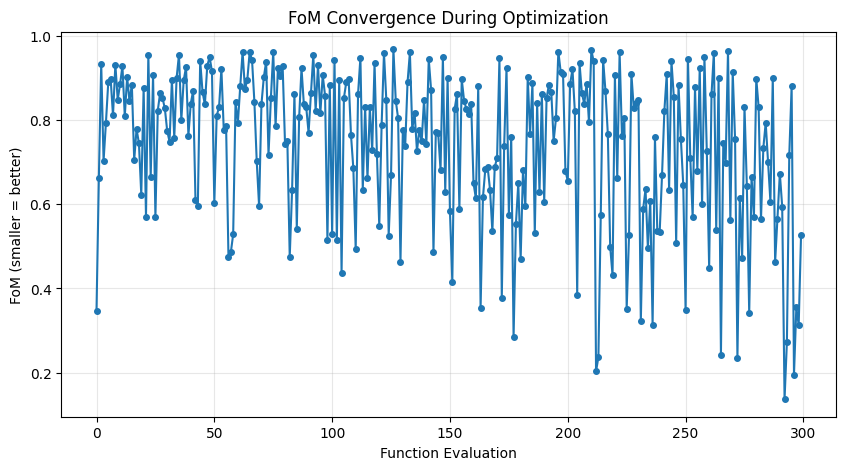

Pulse length (bins): 300


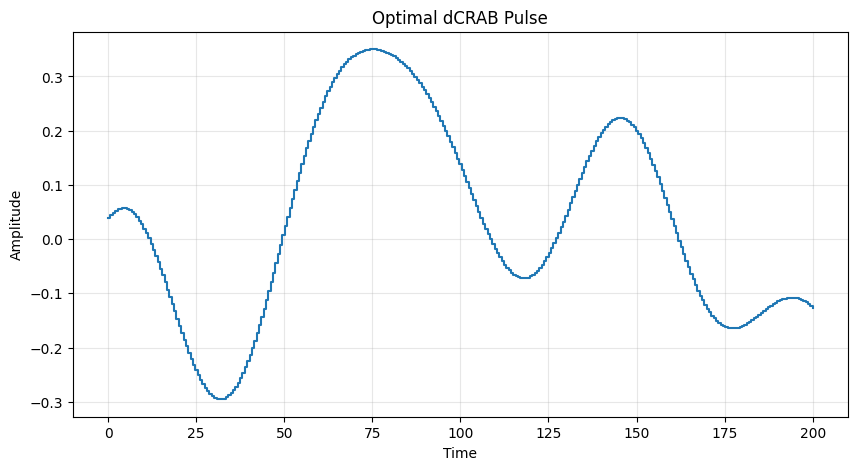

Optimal pulse saved as best_pulse.npy and best_timegrid.npy


In [9]:
import numpy as np
import matplotlib.pyplot as plt


# 1) Retrieve the optimization algorithm object

try:
    opt_alg_obj = optimizer.get_optimization_algorithm()
    print("Optimization algorithm object found.")
except:
    raise RuntimeError("Could not find the 'optimizer' object. "
                       "Make sure you previously executed: optimizer = Optimizer(...).")


# 2) Retrieve FoM history

fomlist = np.array(opt_alg_obj.FoM_list)
print(f"Number of FoM evaluations: {len(fomlist)}")

# Plot FoM vs evaluation count
plt.figure(figsize=(10, 5))
plt.plot(fomlist, '-o', markersize=4)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM (smaller = better)")
plt.title("FoM Convergence During Optimization")
plt.grid(True, alpha=0.3)
plt.show()


# 3) Retrieve the best controls (optimal pulse)

controls = opt_alg_obj.get_best_controls()
pulse = np.array(controls["pulses"][0])
timegrid = np.array(controls["timegrids"][0])

print(f"Pulse length (bins): {len(pulse)}")

# Plot the optimal pulse (step plot)
plt.figure(figsize=(10, 5))
plt.step(timegrid, pulse, where='post')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Optimal dCRAB Pulse")
plt.grid(True, alpha=0.3)
plt.show()


# 4) Save results (optional)

np.save("best_pulse.npy", pulse)
np.save("best_timegrid.npy", timegrid)
print("Optimal pulse saved as best_pulse.npy and best_timegrid.npy")
